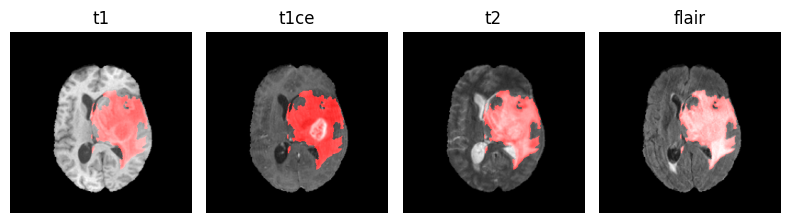

In [53]:
import torch
import torchvision.transforms as transforms
from guided_diffusion.bratsloader import BRATSDataset

tran_list = [transforms.Resize((256,256))]
transform_test = transforms.Compose(tran_list)

ds = BRATSDataset('data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001', transform_test)

datal = torch.utils.data.DataLoader(
    ds,
    batch_size=1,
    shuffle=True)

import matplotlib.pyplot as plt
from scipy import ndimage

b, m, slide_id = next(iter(datal))

from guided_diffusion.utils import visualize, dice_coeff
t1, t1ce, t2, flair = visualize(b, m)


# from guided_diffusion.unet_parts import BasicUNet
# import torch.nn.functional as F
# seg = BasicUNet(n_channels=4, n_classes=1)
# checkpoint = torch.load('model_nonnormalized.pth')
# seg.load_state_dict(checkpoint['model_state_dict'])
# seg.eval()

# ipex_enabled = False
# bf16 = True

# import time
# start_time = time.time()
# if ipex_enabled:
#     import intel_extension_for_pytorch as ipex
#     if bf16:
#         seg = ipex.optimize(seg, dtype=torch.bfloat16)
#         with torch.no_grad(), torch.cpu.amp.autocast():
#             m_pred = F.sigmoid(seg(b.to(torch.float32)))
#     else:
#         seg = ipex.optimize(seg)
#         m_pred = F.sigmoid(seg(b.to(torch.float32))).detach()
# else:
#     m_pred = F.sigmoid(seg(b.to(torch.float32))).detach()

# print(time.time() - start_time)
# print(dice_coeff(m_pred, m))
# visualize(b, m_pred)

In [ ]:
import os
import sys
import random
sys.path.append(".")
import numpy as np
import time
import torch
from guided_diffusion.bratsloader import BRATSDataset
import torchvision.utils as vutils
from guided_diffusion.utils import post_process
from guided_diffusion.script_util import (
    model_and_diffusion_defaults,
    create_model_and_diffusion
)
import torchvision.transforms as transforms


data_dir = 'data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001'
image_size = 256
batch_size = 1
ipex_enabled = True
bf16 = True
num_ensemble = 1
diffusion_steps = 100
in_ch = 5

tran_list = [transforms.Resize((image_size,image_size))]
transform_test = transforms.Compose(tran_list)

ds = BRATSDataset(data_dir,transform_test)

datal = torch.utils.data.DataLoader(
    ds,
    batch_size=batch_size,
    shuffle=True)

model, diffusion = create_model_and_diffusion(image_size=image_size, in_ch=in_ch, diffusion_steps=diffusion_steps, version=1)

######################
# checkpoint = torch.load(model_path)
# model.load_state_dict(checkpoint['model_state_dict'], strict=False)
######################

model.eval()

if ipex_enabled:
    import intel_extension_for_pytorch as ipex
    print("Intel(R) Extension for PyTorch* enabled")
    if bf16:
        print("BF16 enabled")
        model = ipex.optimize(model, dtype=torch.bfloat16)
    else:
        model = ipex.optimize(model)

b, m, slice_ID = next(iter(datal))  #should return an image from the dataloader "data"
c = torch.randn_like(b[:, :1, ...])
img = torch.cat((b, c), dim=1)     #add a noise channel$

enslist = []

for i in range(num_ensemble):  #this is for the generation of an ensemble of 5 masks.
    model_kwargs = {}

    sample_fn = diffusion.p_sample_loop_known
    start_time = time.time()

    if ipex_enabled and bf16:
        with torch.no_grad(), torch.cpu.amp.autocast():
            sample, x_noisy, org, cal, cal_out = sample_fn(
                model,
                (batch_size, in_ch, image_size, image_size), img, ipex_enabled,
                step = diffusion_steps,
                clip_denoised=True,
                model_kwargs=model_kwargs,
            )
    else:
        sample, x_noisy, org, cal, cal_out = sample_fn(
            model,
            (batch_size, in_ch, image_size, image_size), img, 
            ipex_enabled, bf16=False,
            step = diffusion_steps,
            clip_denoised=True,
            model_kwargs=model_kwargs,
        )
        
    ensemble_step_time = time.time() - start_time
    post_processed_m = post_process(sample)

    print("--- %s seconds ---" % (ensemble_step_time))


In [ ]:
from guided_diffusion.utils import visualize, dice_coeff
visualize(img, post_processed_m)

In [ ]:
from guided_diffusion.utils import dice_coeff
dice_coeff(post_processed_m, m)

In [ ]:
import nibabel as nib
img = nib.load('data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_flair.nii.gz')

/mnt/localdisk1/kta/env/MedSegDiff/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


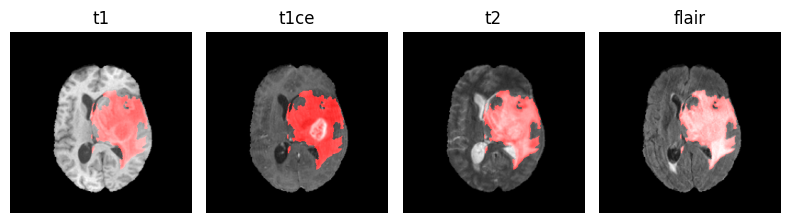

In [2]:
import torch
import torchvision.transforms as transforms
from guided_diffusion.bratsloader import BRATSDataset
from guided_diffusion.utils import visualize

tran_list = [transforms.Resize((256,256))]
transform_test = transforms.Compose(tran_list)

ds = BRATSDataset('data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001', transform_test)

datal = torch.utils.data.DataLoader(
    ds,
    batch_size=1,
    shuffle=True)

b, m, slide_id = next(iter(datal))
t1, t1ce, t2, flair = visualize(b, m)


In [6]:
input_img = '001'
if input_img == '002':
    print('true')

In [8]:
import torch
import torchvision.transforms as transforms
from guided_diffusion.bratsloader import BRATSDataset
from guided_diffusion.utils import visualize

import gradio as gr

def segment_tumor(input_img, sequence_type, optimization):

    tran_list = [transforms.Resize((256,256))]
    transform_test = transforms.Compose(tran_list)

    ds = BRATSDataset(f'data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_{input_img}', transform_test)

    datal = torch.utils.data.DataLoader(
        ds,
        batch_size=1,
        shuffle=True)

    b, m, slide_id = next(iter(datal))
    t1, t1ce, t2, flair = visualize(b, m)
    
    if sequence_type == 't1':
        output_img = t1
    elif sequence_type == 't1ce':
        output_img = t1ce
    elif sequence_type == 't2':
        output_img = t2
    elif sequence_type == 'flair':
        output_img = flair

    return output_img, sequence_type, optimization

demo = gr.Interface(
    fn=segment_tumor, 
    inputs=[gr.Dropdown(['001', '002']), gr.Dropdown(['t1', 't1ce', 't2', 'flair']), gr.Dropdown(['Stock PyTorch*', 'Intel(R) Extension for PyTorch*'])], 
    outputs=["image", "text", "text"], 
    live=False, 
    title="ACCELERATE DIFFUSION MODELS FOR MEDICAL SEGMENTATION",
    css="footer {visibility: hidden}"
)

demo.launch(share=True)

Running on local URL:  http://127.0.0.1:7861
Running on public URL: https://4fcc18afc0ad646c48.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


/mnt/localdisk1/kta/env/MedSegDiff/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/mnt/localdisk1/kta/MedSegDiff/MedSegDiff/guided_diffusion/utils.py:170: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


In [60]:
import torch
import torchvision.transforms as transforms
from guided_diffusion.bratsloader import BRATSDataset
from guided_diffusion.utils import visualize, dice_coeff

import gradio as gr

def segment_tumor(input_img, sequence_type, optimization):

    tran_list = [transforms.Resize((256,256))]
    transform_test = transforms.Compose(tran_list)

    ds = BRATSDataset(f'data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_{input_img}', transform_test)

    datal = torch.utils.data.DataLoader(
        ds,
        batch_size=1,
        shuffle=True)

    b, m, slide_id = next(iter(datal))
    t1, t1ce, t2, flair = visualize(b, m)
    
    if sequence_type == 't1':
        output_img = t1
    elif sequence_type == 't1ce':
        output_img = t1ce
    elif sequence_type == 't2':
        output_img = t2
    elif sequence_type == 'flair':
        output_img = flair
        
    dice_score = f"Dice Coefficient: {dice_coeff(m.int(), m.int()):.2f}"

    return output_img, dice_score


demo = gr.Interface(
    fn=segment_tumor, 
    inputs=[gr.Dropdown(['001', '002'], label="Input Image"), 
            gr.Dropdown(['t1', 't1ce', 't2', 'flair'], label="Sequence Type"), 
            gr.Dropdown(['Stock PyTorch*', 'Intel(R) Extension for PyTorch*'], label="Optimization")], 
    outputs=[gr.Image(label="Tumor Segmentation Prediction"),
             gr.Textbox(label="Accuracy")], 
    live=False, 
    title="ACCELERATE DIFFUSION MODELS FOR MEDICAL SEGMENTATION",
    allow_flagging='never',
    css="footer {visibility: hidden}",
)

demo.launch(share=True)

/mnt/localdisk1/kta/env/MedSegDiff/lib/python3.10/site-packages/gradio/blocks.py:695: UserWarning: Cannot load darkdefault. Caught Exception: The space darkdefault does not exist
  warnings.warn(f"Cannot load {theme}. Caught Exception: {str(e)}")


Running on local URL:  http://127.0.0.1:7865
Running on public URL: https://19e7f24011d2361bb3.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


In [32]:
dice_score = f"Dice Coefficient: {dice_coeff(m.squeeze(), m.squeeze()):.2f}"
print(dice_score)

Dice Coefficient: 0.98
